## Tuning Adam on MNIST and plotting the results

# 1.Imports & environment

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
import gzip
import numpy as np
import sys
# os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# Setup predictable randomization
seed = 10
np.random.seed(seed)

# Setup CUda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Loading and preparing the data
As a basis for comparison we will be using the MNIST dataset. If we manage to do all the work we want, we will then use other datasets for comparison.

### 2.1. Definition of methods to extract data and labels

 Source: Image Analysis and Pattern Recognition (EE-451) lab 3

In [4]:
def extract_data(filename, image_shape, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(np.prod(image_shape) * image_number)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(image_number, image_shape[0], image_shape[1])
    return data


def extract_labels(filename, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * image_number)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    return labels

### 2.2. Load data

In [5]:
image_shape = (28, 28)
train_set_size = 60000
test_set_size = 10000
data_folder = 'drive/MyDrive/mnist_data'

train_images_path = os.path.join(data_folder, 'train-images-idx3-ubyte.gz')
train_labels_path = os.path.join(data_folder, 'train-labels-idx1-ubyte.gz')
test_images_path = os.path.join(data_folder, 't10k-images-idx3-ubyte.gz')
test_labels_path = os.path.join(data_folder, 't10k-labels-idx1-ubyte.gz')

train_images = extract_data(train_images_path, image_shape, train_set_size)
test_images = extract_data(test_images_path, image_shape, test_set_size)
train_labels = extract_labels(train_labels_path, train_set_size)
test_labels = extract_labels(test_labels_path, test_set_size)

### 2.3. Convert data from numpy arrays to torch tensors

In [6]:
features_train=torch.from_numpy(train_images).to(device)
features_test=torch.from_numpy(test_images).to(device)
print('Training features:', features_train.shape, '\n'
'Testing features:', features_test.shape)

labels_train=torch.from_numpy(train_labels).to(device)
labels_test=torch.from_numpy(test_labels).to(device)
print('Training labels:', labels_train.shape, '\n'
'Testing labels:', labels_test.shape)

Training features: torch.Size([60000, 28, 28]) 
Testing features: torch.Size([10000, 28, 28])
Training labels: torch.Size([60000]) 
Testing labels: torch.Size([10000])


### 2.4. Normalize data

In [7]:
mean, std = features_train.float().mean(), features_train.float().std()

features_train = features_train.float().sub_(mean).div_(std)
features_test = features_test.float().sub_(mean).div_(std)

In [8]:
#reshape to make the 1st channel be a batch size

features_train = features_train.reshape(-1, 1, 28, 28)
features_test = features_test.reshape(-1, 1, 28, 28)

# 3. Setting up networks and evaluation methods

### 3.1. Multilayer perceptron (MLP)

In [14]:
class MLP(nn.Module):
    
    def __init__(self, hidden_size_1=512, hidden_size_2=100, hidden_size_3=10):
        super(MLP, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, hidden_size_1),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_size_1, hidden_size_2),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_size_2, hidden_size_3))
    
    def forward(self, x):
        return self.layers(x)

###3.2. Convolutional Neural Network (CNN)

In [9]:
class CNN(nn.Module):
   def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 32, kernel_size=5, stride=1, padding='same')
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=5, stride=1, padding='same')
        self.fc1 = nn.Linear(64*7*7, 1024)
        self.fc2 = nn.Linear(1024, 10)

   def forward(self, input:torch.Tensor) -> torch.Tensor:
        pool1 = torch.max_pool2d(F.relu(self.conv1(input)), kernel_size=2, stride=2)
        pool2 = torch.max_pool2d(F.relu(self.conv2(pool1)), kernel_size=2, stride=2)
        res = pool2.reshape(-1, 64*7*7)
        hidden = F.relu(self.fc1(res))
        output = self.fc2(hidden)

        return output


### 3.3. Implementation of method for training

In [10]:
def run_nn(x_train, y_train, x_test, y_test, model, optimizer, criterion, num_epoch, size_minibatch):

    loss_train_ret = 0
    loss_test_ret = 0
    loss_train = 0
            
    for epoch in range(num_epoch):
        for b in range(0, x_train.size(0), size_minibatch):
            y = model(x_train[b:b+size_minibatch])
            loss_train = criterion(y, y_train[b:b+size_minibatch])
        
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()

        if epoch == num_epoch - 1:

            y_test_obt = model(x_test)
            loss_test = criterion(y_test_obt, y_test)
            
            loss_train_ret = loss_train
            loss_test_ret = loss_test
            
            print('Final, Train Loss: %.4f, Test Loss: %.4f' %(loss_train, loss_test))

    return loss_train_ret, loss_test_ret

# 4. Metrics of our tuning protocol
At this stage, we want to select the hyperparameter search space for each optimizer. This way, we can first tune the hyperparameters of each optimizer separately and then select the trial that achieved lowest final train and test error.
We then comapre the optimizers' performance by looking at the train and test errors as suggested in the paper "On empirical comparisons of optimizers for deep learning".

No regularization or weight decay is used.

### 4.1. Tuning protocol using bootstrap
To estimate means and uncertainties of our tuning protocol we will use bootstrapping starting from an initial search space suggested by the paper "On Empirical Comparisons of Optimizers for Deep Learning".
We run N trials by randomly picking values in the search space of the algorithm at every trial.
Then we sample these trials with replacement and compute our statistic on the first K trials of this sample. We repeat this process 50 or 100 times and compute the 5th percentile and 95th percentile of the bootstrap distribution.

This allows us to plot the error bars to show the results.

### 4.2. Tuning Adam for the MLP on MNIST
The hyperparameters we are tuning are alpha_0/epsilon, 1 - beta_1, 1 - beta_2, epsilon.
The initial search spaces are suggested based on the experience of the writers of the same paper, "On empirical comparisons of optimizers for deep learning".

##### Set up model for training

In [15]:
# Model fixed parameters
model = MLP()
model = model.to(device)
criterion = nn.CrossEntropyLoss().to(device) # good loss function for classification tasks
num_epoch = 50
size_minibatch = 128

x_train = features_train
y_train = labels_train
x_test = features_test
y_test = labels_test

##### Tune to find best parameter
We perform trials until we have K of them, then we pick the best based on our statistic of interest

#### 4.2.1. Initial search for best hyperparameters for **Adam** optimizer on **MLP**. K= 100. 
Interrupted because of nan loss.

##### Set up parameters and search space for the initial trial

In [ ]:
N = 200
K = 100 # Number of trials being kept for the statistic

# Initial search spaces for parameters
alpha_0 = np.linspace(10**(-2), 10**(4), N)
beta_1 = np.linspace(10**(-3), 1, N)
beta_2 = np.linspace(10**(-4), 1, N)
eps = np.linspace(10**(-10), 10**(10), N)

Perform search

In [ ]:
nb_hyperamaters_to_tune = 4
nb_exported_statistics  = 2

lowest_test_error = [sys.maxsize] * (nb_hyperamaters_to_tune + nb_exported_statistics)

for _ in range(K):
    # Pick random values from the intervals given for the different parameters
    alpha_0_pick  = float(np.random.choice(alpha_0, 1)) # np.random.choice samples uniformely with replacement
    beta_1_pick   = float(-np.random.choice(beta_1, 1) + 1)
    beta_2_pick   = float(-np.random.choice(beta_2, 1) + 1)
    eps_pick      = float(np.random.choice(eps, 1))
    learning_rate = alpha_0_pick * eps_pick
    
    # Build optimizer from parameters
    model=MLP()
    model=model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(beta_1_pick, beta_2_pick), eps=eps_pick)
    
    # Run
    train_error, test_error = run_nn(x_train,y_train, x_test, y_test, model, optimizer, criterion, num_epoch, size_minibatch)
    
    # Concatenate hyperparameters with results
    vector = [beta_1_pick, beta_2_pick, eps_pick, learning_rate, train_error, test_error]
    
    # Check wether we have the smallest test error and store parameters in case we find it
    if test_error < lowest_test_error[len(lowest_test_error) - 1]:
        lowest_test_error = vector

Final, Train Loss: nan, Test Loss: nan
Final, Train Loss: nan, Test Loss: nan
Final, Train Loss: 0.4954, Test Loss: 0.4477
Final, Train Loss: nan, Test Loss: nan
Final, Train Loss: nan, Test Loss: nan
Final, Train Loss: nan, Test Loss: nan
Final, Train Loss: nan, Test Loss: nan
Final, Train Loss: nan, Test Loss: nan
Final, Train Loss: nan, Test Loss: nan
Final, Train Loss: nan, Test Loss: nan
Final, Train Loss: nan, Test Loss: nan
Final, Train Loss: nan, Test Loss: nan
Final, Train Loss: nan, Test Loss: nan
Final, Train Loss: nan, Test Loss: nan
Final, Train Loss: nan, Test Loss: nan
Final, Train Loss: nan, Test Loss: nan
Final, Train Loss: nan, Test Loss: nan
Final, Train Loss: nan, Test Loss: nan
Final, Train Loss: nan, Test Loss: nan
Final, Train Loss: nan, Test Loss: nan
Final, Train Loss: nan, Test Loss: nan
Final, Train Loss: nan, Test Loss: nan
Final, Train Loss: nan, Test Loss: nan
Final, Train Loss: nan, Test Loss: nan
Final, Train Loss: nan, Test Loss: nan
Final, Train Loss: 

KeyboardInterrupt: ignored

#### 4.2.2. Final search for best hyperparameters for **Adam** optimizer on **MLP**. K = 50

##### Set up parameters and search space for the final trial

In [ ]:
N = 200
K = 50 # Number of trials being kept for the statistic

# Final search spaces for parameters
alpha_0 = np.linspace(10**(-1), 10, N)
beta_1 = np.linspace(10**(-3), 1, N)
beta_2 = np.linspace(10**(-4), 1, N)
eps = np.linspace(10**(-6), 10**(-2), N)

Perform search

In [ ]:
nb_hyperamaters_to_tune = 4
nb_exported_statistics  = 2

lowest_test_error = [sys.maxsize] * (nb_hyperamaters_to_tune + nb_exported_statistics)


for _ in range(K):
    # Pick random values from the intervals given for the different parameters
    alpha_0_pick  = float(np.random.choice(alpha_0, 1)) # np.random.choice samples uniformely with replacement
    beta_1_pick   = float(-np.random.choice(beta_1, 1) + 1)
    beta_2_pick   = float(-np.random.choice(beta_2, 1) + 1)
    eps_pick      = float(np.random.choice(eps, 1))
    learning_rate = alpha_0_pick * eps_pick
    
    # Build optimizer from parameters
    model = MLP()
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(beta_1_pick, beta_2_pick), eps=eps_pick)
    
    # Run
    train_error, test_error = run_nn(x_train,y_train, x_test, y_test, model, optimizer, criterion, num_epoch, size_minibatch)
    
    # Concatenate hyperparameters with results
    vector = [beta_1_pick, beta_2_pick, eps_pick, learning_rate, train_error, test_error]
    
    # Check wether we have the smallest test error and store parameters in case we find it
    if test_error < lowest_test_error[len(lowest_test_error) - 1]:
        lowest_test_error = vector

Final, Train Loss: 0.1809, Test Loss: 0.6990
Final, Train Loss: 0.0476, Test Loss: 0.4258
Final, Train Loss: 2.1889, Test Loss: 2.1555
Final, Train Loss: 1.0889, Test Loss: 0.5313
Final, Train Loss: 0.0000, Test Loss: 0.1779
Final, Train Loss: 0.0000, Test Loss: 0.0964
Final, Train Loss: 0.0000, Test Loss: 0.1362
Final, Train Loss: 0.0006, Test Loss: 0.0769
Final, Train Loss: 0.0003, Test Loss: 0.3194
Final, Train Loss: 0.1132, Test Loss: 0.4826
Final, Train Loss: 0.0000, Test Loss: 0.3511
Final, Train Loss: 0.1975, Test Loss: 0.1361
Final, Train Loss: 0.0444, Test Loss: 0.5672
Final, Train Loss: 0.0002, Test Loss: 0.0817
Final, Train Loss: 0.0937, Test Loss: 0.7164
Final, Train Loss: 0.0000, Test Loss: 0.2495
Final, Train Loss: 1.8274, Test Loss: 1.9169
Final, Train Loss: 2.3033, Test Loss: 2.3022
Final, Train Loss: 1.6200, Test Loss: 2.3105
Final, Train Loss: 2.3062, Test Loss: 2.3021
Final, Train Loss: 2.3056, Test Loss: 2.3013
Final, Train Loss: 2.1334, Test Loss: 2.0490
Final, Tra

In [ ]:
# Print best parameters

print('Beta 1: %.2f' % lowest_test_error[0])
print('Beta 2: %.2f' % lowest_test_error[1])
print('Epsilon: %.2e' % lowest_test_error[2])
print('Learning rate: %.6f' % lowest_test_error[3])
print('Train error: %.6f' % lowest_test_error[4])
print('Test error: %.4f' % lowest_test_error[5])

Beta 1: 0.21
Beta 2: 0.69
Epsilon: 4.27e-03
Learning rate: 0.000427
Train error: 0.000572
Test error: 0.0769


Run the model again with the best parameters to plot the convergence later

In [ ]:
model = MLP()
model = model.to(device)
learning_rate = lowest_test_error[3]
beta_1 = lowest_test_error[0]
beta_2 = lowest_test_error[1]
eps = lowest_test_error[2]
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(beta_1, beta_2), eps=eps)
    
loss_all_train_mlp, loss_all_test_mlp = [], []
            
for epoch in range(num_epoch):
     for b in range(0, x_train.size(0), size_minibatch):
            y = model(x_train[b:b+size_minibatch])
            loss_train = criterion(y, y_train[b:b+size_minibatch])
        
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()

     loss_train = loss_train.to('cpu').detach().numpy()
     loss_all_train_mlp.append(loss_train)

     y_test_obt = model(x_test)
     loss_test = criterion(y_test_obt, y_test)
     loss_test = loss_test.to('cpu').detach().numpy()
     loss_all_test_mlp.append(loss_test)
     if epoch == num_epoch - 1 :
        print('Final, Train Loss: %.4f, Test Loss: %.4f' %(loss_train, loss_test))

Final, Train Loss: 0.0006, Test Loss: 0.0760


##### 4.2.3. Estimating trial outcomes via bootstrap
At this stage we want to estimate means and uncertainties of our tuning protocol

###### Run N trials

In [ ]:
# We first run and store N trials
N=200
N_trials = []


for _ in range(N):
    # Pick random values from the intervals given for the different parameters
    alpha_0_pick  = float(np.random.choice(alpha_0, 1)) # np.random.choice samples uniformely with replacement
    beta_1_pick   = float(-np.random.choice(beta_1, 1) + 1)
    beta_2_pick   = float(-np.random.choice(beta_2, 1) + 1)
    eps_pick      = float(np.random.choice(eps, 1))
    learning_rate = alpha_0_pick * eps_pick
    
    # Build optimizer from parameters
    model = MLP()
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(beta_1_pick, beta_2_pick), eps=eps_pick)
    
    # Run
    train_error, test_error = run_nn(x_train,y_train, x_test, y_test, model, optimizer, criterion, num_epoch, size_minibatch)
    
    # Store parameters, train and test error
    N_trials.append([beta_1_pick, beta_2_pick, eps_pick, learning_rate, train_error.item(), test_error.item()])

Final, Train Loss: 0.0001, Test Loss: 0.3323
Final, Train Loss: 1.8190, Test Loss: 1.9930
Final, Train Loss: 2.3077, Test Loss: 2.3014
Final, Train Loss: 1.6570, Test Loss: 2.6781
Final, Train Loss: 2.3139, Test Loss: 2.2030
Final, Train Loss: 1.9307, Test Loss: 2.3562
Final, Train Loss: 2.3055, Test Loss: 2.3017
Final, Train Loss: 0.0277, Test Loss: 0.6947
Final, Train Loss: 2.3085, Test Loss: 2.3019
Final, Train Loss: 1.5564, Test Loss: 0.9790
Final, Train Loss: 0.0688, Test Loss: 0.5211
Final, Train Loss: 2.1636, Test Loss: 2.0797
Final, Train Loss: 1.1641, Test Loss: 1.3472
Final, Train Loss: 1.3095, Test Loss: 0.7236
Final, Train Loss: 0.0616, Test Loss: 0.5079
Final, Train Loss: 2.0921, Test Loss: 1.6448
Final, Train Loss: 2.3069, Test Loss: 2.3022
Final, Train Loss: 2.0068, Test Loss: 2.3230
Final, Train Loss: 2.3067, Test Loss: 2.3015
Final, Train Loss: 0.0003, Test Loss: 0.0792
Final, Train Loss: 0.0012, Test Loss: 0.0760
Final, Train Loss: 0.0294, Test Loss: 0.2719
Final, Tra

In [ ]:
# save the results

import pickle
with open("N_trials_adam_mlp.pth", "wb") as fp:
  pickle.dump(N_trials, fp)

### 4.3. Tuning Adam for the CNN on MNIST

##### Set up model for training

In [12]:
# Model fixed parameters
model = CNN()
model = model.to(device)
criterion = nn.CrossEntropyLoss().to(device) # good loss function for classification tasks
num_epoch = 50
size_minibatch = 128

x_train = features_train
y_train = labels_train
x_test = features_test
y_test = labels_test

##### Tune to find best parameter
We perform trials until we have K of them, then we pick the best based on our statistic of interest

#### 4.3.1. Initial search for best hyperparameters for **Adam** optimizer on **CNN**. K= 100. 
Interrupted because of nan loss.

##### Set up parameters and search space for the initial trial

In [ ]:
N = 200
K = 100 # Number of trials being kept for the statistic

# Initial search spaces for parameters
alpha_0 = np.linspace(10**(-2), 10**(4), N)
beta_1 = np.linspace(10**(-3), 1, N)
beta_2 = np.linspace(10**(-4), 1, N)
eps = np.linspace(10**(-10), 10**(10), N)

Perform search

In [ ]:
nb_hyperamaters_to_tune = 4
nb_exported_statistics  = 2

lowest_test_error = [sys.maxsize] * (nb_hyperamaters_to_tune + nb_exported_statistics)

for _ in range(K):
    # Pick random values from the intervals given for the different parameters
    alpha_0_pick  = float(np.random.choice(alpha_0, 1)) # np.random.choice samples uniformely with replacement
    beta_1_pick   = float(-np.random.choice(beta_1, 1) + 1)
    beta_2_pick   = float(-np.random.choice(beta_2, 1) + 1)
    eps_pick      = float(np.random.choice(eps, 1))
    learning_rate = alpha_0_pick * eps_pick
    
    # Build optimizer from parameters
    model=CNN()
    model=model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(beta_1_pick, beta_2_pick), eps=eps_pick)
    
    # Run
    train_error, test_error = run_nn(x_train,y_train, x_test, y_test, model, optimizer, criterion, num_epoch, size_minibatch)
    
    
    # Concatenate hyperparameters with results
    vector = [beta_1_pick, beta_2_pick, eps_pick, learning_rate, train_error, test_error]
    
    # Check wether we have the smallest test error and store parameters in case we find it
    if test_error < lowest_test_error[len(lowest_test_error) - 1]:
        lowest_test_error = vector

Final, Train Loss: nan, Test Loss: nan
Final, Train Loss: nan, Test Loss: nan
Final, Train Loss: 0.2574, Test Loss: 0.1889
Final, Train Loss: nan, Test Loss: nan
Final, Train Loss: nan, Test Loss: nan
Final, Train Loss: nan, Test Loss: nan
Final, Train Loss: nan, Test Loss: nan
Final, Train Loss: nan, Test Loss: nan
Final, Train Loss: nan, Test Loss: nan
Final, Train Loss: nan, Test Loss: nan


KeyboardInterrupt: ignored

#### 4.3.2. Final search for best hyperparameters for **Adam** optimizer on **CNN**. K = 50

##### Set up parameters and search space for the final trial

In [ ]:
N = 200
K = 50 # Number of trials being kept for the statistic

# Final search spaces for parameters
alpha_0 = np.linspace(10**(-1), 10, N)
beta_1 = np.linspace(10**(-3), 1, N)
beta_2 = np.linspace(10**(-4), 1, N)
eps = np.linspace(10**(-6), 10**(-2), N)

Perform search

In [ ]:
nb_hyperamaters_to_tune = 4
nb_exported_statistics  = 2

lowest_test_error = [sys.maxsize] * (nb_hyperamaters_to_tune + nb_exported_statistics)


for _ in range(K):
    # Pick random values from the intervals given for the different parameters
    alpha_0_pick  = float(np.random.choice(alpha_0, 1)) # np.random.choice samples uniformely with replacement
    beta_1_pick   = float(-np.random.choice(beta_1, 1) + 1)
    beta_2_pick   = float(-np.random.choice(beta_2, 1) + 1)
    eps_pick      = float(np.random.choice(eps, 1))
    learning_rate = alpha_0_pick * eps_pick
    
    # Build optimizer from parameters
    model=CNN()
    model=model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(beta_1_pick, beta_2_pick), eps=eps_pick)
    
    # Run
    train_error, test_error = run_nn(x_train,y_train, x_test, y_test, model, optimizer, criterion, num_epoch, size_minibatch)
    
    # Concatenate hyperparameters with results
    vector = [beta_1_pick, beta_2_pick, eps_pick, learning_rate, train_error, test_error]
    
    # Check wether we have the smallest test error and store parameters in case we find it
    if test_error < lowest_test_error[len(lowest_test_error) - 1]:
        lowest_test_error = vector

Final, Train Loss: 0.0000, Test Loss: 0.0360
Final, Train Loss: 2.3075, Test Loss: 2.3020
Final, Train Loss: 0.1967, Test Loss: 0.0366
Final, Train Loss: 0.0000, Test Loss: 0.0545
Final, Train Loss: 2.3060, Test Loss: 2.3016
Final, Train Loss: 0.0000, Test Loss: 0.3814
Final, Train Loss: 0.0000, Test Loss: 0.5991
Final, Train Loss: 2.3062, Test Loss: 2.3016
Final, Train Loss: 2.3066, Test Loss: 2.3016
Final, Train Loss: 0.0000, Test Loss: 0.0849
Final, Train Loss: 0.0390, Test Loss: 0.3894
Final, Train Loss: 0.1512, Test Loss: 0.1367
Final, Train Loss: 2.3085, Test Loss: 2.3019
Final, Train Loss: 0.0000, Test Loss: 0.5518
Final, Train Loss: 0.0000, Test Loss: 0.0458
Final, Train Loss: 2.3084, Test Loss: 2.3019
Final, Train Loss: 0.0000, Test Loss: 0.0604
Final, Train Loss: 2.3063, Test Loss: 2.3020
Final, Train Loss: 2.3055, Test Loss: 2.3019
Final, Train Loss: 0.1624, Test Loss: 0.2472
Final, Train Loss: 2.3083, Test Loss: 2.3020
Final, Train Loss: 0.0000, Test Loss: 0.0397
Final, Tra

In [ ]:
# Print best parameters

print('Beta 1: %.2f' % lowest_test_error[0])
print('Beta 2: %.2f' % lowest_test_error[1])
print('Epsilon: %.2e' % lowest_test_error[2])
print('Learning rate: %.2e' % lowest_test_error[3])
print('Train error: %.6f' % lowest_test_error[4])
print('Test error: %.4f' % lowest_test_error[5])

Beta 1: 0.37
Beta 2: 0.92
Epsilon: 3.22e-03
Learning rate: 1.76e-03
Train error: 0.000005
Test error: 0.0360


Run the model again with the best parameters to plot the convergence later.

In [13]:
model = CNN()
model = model.to(device)
learning_rate =  lowest_test_error[3]
beta_1 = lowest_test_error[0]
beta_2 = lowest_test_error[1]
eps = lowest_test_error[2]
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(beta_1, beta_2), eps=eps)
    
loss_all_train_cnn, loss_all_test_cnn = [], []
            
for epoch in range(num_epoch):
     for b in range(0, x_train.size(0), size_minibatch):
            y = model(x_train[b:b+size_minibatch])
            loss_train = criterion(y, y_train[b:b+size_minibatch])
        
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
      
     loss_train = loss_train.to('cpu').detach().numpy()
     loss_all_train_cnn.append(loss_train)

     y_test_obt = model(x_test)
     loss_test = criterion(y_test_obt, y_test)
     loss_test = loss_test.to('cpu').detach().numpy()
     loss_all_test_cnn.append(loss_test)
     if epoch == num_epoch - 1 :
        print('Final, Train Loss: %.4f, Test Loss: %.4f' %(loss_train, loss_test))

Final, Train Loss: 0.0000, Test Loss: 0.0367


##### 4.3.3. Estimating trial outcomes via bootstrap
At this stage we want to estimate means and uncertainties of our tuning protocol

###### Run N trials

###### Perform bootstrapping

In [ ]:
N = 50
K = 25

# Final search spaces for parameters
alpha_0 = np.linspace(10**(-1), 10, N)
beta_1 = np.linspace(10**(-3), 1, N)
beta_2 = np.linspace(10**(-4), 1, N)
eps = np.linspace(10**(-6), 10**(-2), N)

In [ ]:
# We first run and store N trials
N_trials = []

for _ in range(N):
    # Pick random values from the intervals given for the different parameters
    alpha_0_pick  = float(np.random.choice(alpha_0, 1)) # np.random.choice samples uniformely with replacement
    beta_1_pick   = float(-np.random.choice(beta_1, 1) + 1)
    beta_2_pick   = float(-np.random.choice(beta_2, 1) + 1)
    eps_pick      = float(np.random.choice(eps, 1))
    learning_rate = alpha_0_pick * eps_pick
    
    # Build optimizer from parameters
    model = CNN()
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(beta_1_pick, beta_2_pick), eps=eps_pick)
    
    # Run
    train_error, test_error = run_nn(x_train,y_train, x_test, y_test, model, optimizer, criterion, num_epoch, size_minibatch)
    
    # Store parameters, train and test error

    N_trials.append([beta_1_pick, beta_2_pick, eps_pick, learning_rate, train_error.item(), test_error.item()])

Final, Train Loss: 0.2178, Test Loss: 0.0870
Final, Train Loss: 2.3087, Test Loss: 2.3022
Final, Train Loss: 2.3063, Test Loss: 2.3026
Final, Train Loss: 2.3045, Test Loss: 2.3010
Final, Train Loss: 2.3067, Test Loss: 2.3030
Final, Train Loss: 0.0909, Test Loss: 0.8008
Final, Train Loss: 0.0000, Test Loss: 0.3051
Final, Train Loss: 1.0839, Test Loss: 0.4106
Final, Train Loss: 0.0000, Test Loss: 0.5906
Final, Train Loss: 0.0000, Test Loss: 0.0711
Final, Train Loss: 0.0246, Test Loss: 1.0186
Final, Train Loss: 2.3055, Test Loss: 2.3017
Final, Train Loss: 0.2376, Test Loss: 0.4517
Final, Train Loss: 0.2236, Test Loss: 0.4607
Final, Train Loss: 0.0002, Test Loss: 0.3177
Final, Train Loss: 0.0000, Test Loss: 0.4322
Final, Train Loss: 2.3071, Test Loss: 2.3018
Final, Train Loss: 0.0000, Test Loss: 0.2491
Final, Train Loss: 0.0000, Test Loss: 0.1825
Final, Train Loss: 2.3059, Test Loss: 2.3015
Final, Train Loss: 0.1232, Test Loss: 0.7462
Final, Train Loss: 2.3083, Test Loss: 2.3026
Final, Tra

In [ ]:
#save the results

import pickle
with open("N_trials_adam_cnn.pth", "wb") as fp:
  pickle.dump(N_trials, fp)

Plots of convergence on CNN

In [ ]:
# load the results

file = open("plot_nosadam_cnn_train.pth", "rb")
loss_all_train_cnn_nos = pickle.load(file)

In [ ]:
# load the results

file = open("plot_nosadam_cnn_test.pth", "rb")
loss_all_test_cnn_nos = pickle.load(file)

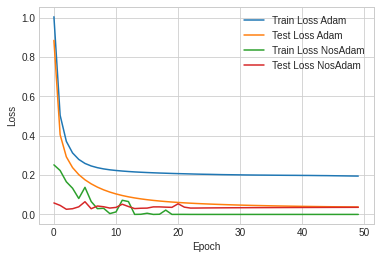

In [ ]:
from IPython.core.pylabtools import figsize
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

epochs = np.arange(0, 50, 1)

plt.plot(epochs, loss_all_train_cnn, label='Train Loss Adam')
plt.plot(epochs, loss_all_test_cnn, label='Test Loss Adam')
plt.plot(epochs, loss_all_train_cnn_nos, label='Train Loss NosAdam')
plt.plot(epochs, loss_all_test_cnn_nos, label='Test Loss NosAdam')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('cnn_conv.pdf')

plt.show()

Plots of convergence on MLP

In [ ]:
# load the results

file = open("plot_nosadam_mlp_train.pth", "rb")
loss_all_train_mlp_nos = pickle.load(file)

In [ ]:
# load the results

file = open("plot_nosadam_mlp_test.pth", "rb")
loss_all_test_mlp_nos = pickle.load(file)

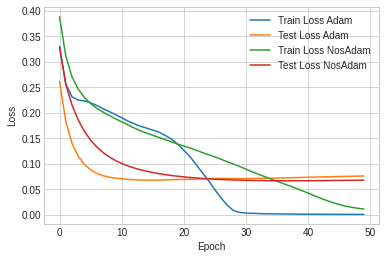

In [ ]:
from IPython.core.pylabtools import figsize
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

epochs = np.arange(0, 50, 1)

plt.plot(epochs, loss_all_train_mlp, label='Train Loss Adam')
plt.plot(epochs, loss_all_test_mlp, label='Test Loss Adam')
plt.plot(epochs, loss_all_train_mlp_nos, label='Train Loss NosAdam')
plt.plot(epochs, loss_all_test_mlp_nos, label='Test Loss NosAdam')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('mlp_conv.pdf')

plt.show()

### Bootstrapping

In [ ]:
# load the results

import pickle
file = open("N_trials_adam_mlp.pth", "rb")
N_trials_adam_mlp = pickle.load(file)

In [ ]:
# load the results

import pickle
file = open("N_trials_nosadam_mlp.pth", "rb")
N_trials_nosadam_mlp = pickle.load(file)

In [ ]:
# load the results

import pickle
file = open("N_trials_adam_cnn.pth", "rb")
N_trials_adam_cnn = pickle.load(file)

In [ ]:
# load the results

import pickle
file = open("N_trials_nosadam_cnn.pth", "rb")
N_trials_nosadam_cnn = pickle.load(file)

Bootstrapping for Adam on MLP

In [ ]:
N=50
K=25
N_trials = N_trials_adam_mlp

means_train = []
means_test  = []
# Do the following 50 times :
for _ in range(50):
    # Resample N samples from the N-trials with replacement
    N_sampled_indices = np.random.choice(list(range(len(N_trials))), N) # choose random indices in the list of N trials
    
    # Recover the lists associated to the indices and keep only intersting information, i.e. test and train errors
    N_sampled_train_error = np.array([N_trials[i][4].cpu().detach().numpy() for i in N_sampled_indices])
    N_sampled_test_error = np.array([N_trials[i][5].cpu().detach().numpy() for i in N_sampled_indices])
    
    # Compute statistic on the first K trials of the resampled dataset
    means_train.append(N_sampled_train_error[:K].mean())
    means_test.append(N_sampled_test_error[:K].mean())
    
# 5th percentile, 95 percentile of bootrap distribution
fifth_percentile_train_adam_mlp = np.percentile(means_train, 5)
fifth_percentile_test_adam_mlp = np.percentile(means_test, 5)

ninety_fifth_percentile_train_adam_mlp = np.percentile(means_train, 95)
ninety_fifth_percentile_test_adam_mlp = np.percentile(means_test, 95)

# For plotting purposes only
mean_all_train_adam_mlp = np.array(means_train).mean()
mean_all_test_adam_mlp = np.array(means_test).mean()

Bootstrapping for NosAdam on MLP

In [ ]:
N=50
K=25
N_trials = N_trials_nosadam_mlp

means_train = []
means_test  = []
# Do the following 50 times :
for _ in range(50):
    # Resample N samples from the N-trials with replacement
    N_sampled_indices = np.random.choice(list(range(len(N_trials))), N) # choose random indices in the list of N trials
    
    # Recover the lists associated to the indices and keep only intersting information, i.e. test and train errors
    N_sampled_train_error = np.array([N_trials[i][4].cpu().detach().numpy() for i in N_sampled_indices])
    N_sampled_test_error = np.array([N_trials[i][5].cpu().detach().numpy() for i in N_sampled_indices])
    
    # Compute statistic on the first K trials of the resampled dataset
    means_train.append(N_sampled_train_error[:K].mean())
    means_test.append(N_sampled_test_error[:K].mean())
    
# 5th percentile, 95 percentile of bootrap distribution
fifth_percentile_train_nosadam_mlp = np.percentile(means_train, 5)
fifth_percentile_test_nosadam_mlp = np.percentile(means_test, 5)

ninety_fifth_percentile_train_nosadam_mlp = np.percentile(means_train, 95)
ninety_fifth_percentile_test_nosadam_mlp = np.percentile(means_test, 95)

# For plotting purposes only
mean_all_train_nosadam_mlp = np.array(means_train).mean()
mean_all_test_nosadam_mlp = np.array(means_test).mean()

Bootstrapping for Adam on CNN

In [ ]:
N=50
K=25
N_trials = N_trials_adam_cnn

means_train = []
means_test  = []
# Do the following 50 times :
for _ in range(50):
    # Resample N samples from the N-trials with replacement
    N_sampled_indices = np.random.choice(list(range(len(N_trials))), N) # choose random indices in the list of N trials
    
    # Recover the lists associated to the indices and keep only intersting information, i.e. test and train errors
    N_sampled_train_error = np.array([N_trials[i][4] for i in N_sampled_indices])
    N_sampled_test_error = np.array([N_trials[i][5] for i in N_sampled_indices])
    
    # Compute statistic on the first K trials of the resampled dataset
    means_train.append(N_sampled_train_error[:K].mean())
    means_test.append(N_sampled_test_error[:K].mean())
    
# 5th percentile, 95 percentile of bootrap distribution
fifth_percentile_train_adam_cnn = np.percentile(means_train, 5)
fifth_percentile_test_adam_cnn = np.percentile(means_test, 5)

ninety_fifth_percentile_train_adam_cnn = np.percentile(means_train, 95)
ninety_fifth_percentile_test_adam_cnn = np.percentile(means_test, 95)

# For plotting purposes only
mean_all_train_adam_cnn = np.array(means_train).mean()
mean_all_test_adam_cnn = np.array(means_test).mean()

Bootstrapping for NosAdam on CNN

In [ ]:
N=50
K=25
N_trials = N_trials_nosadam_cnn

means_train = []
means_test  = []
# Do the following 50 times :
for _ in range(50):
    # Resample N samples from the N-trials with replacement
    N_sampled_indices = np.random.choice(list(range(len(N_trials))), N) # choose random indices in the list of N trials
    
    # Recover the lists associated to the indices and keep only intersting information, i.e. test and train errors
    N_sampled_train_error = np.array([N_trials[i][4] for i in N_sampled_indices])
    N_sampled_test_error = np.array([N_trials[i][5] for i in N_sampled_indices])
    
    # Compute statistic on the first K trials of the resampled dataset
    means_train.append(N_sampled_train_error[:K].mean())
    means_test.append(N_sampled_test_error[:K].mean())
    
# 5th percentile, 95 percentile of bootrap distribution
fifth_percentile_train_nosadam_cnn = np.percentile(means_train, 5)
fifth_percentile_test_nosadam_cnn = np.percentile(means_test, 5)

ninety_fifth_percentile_train_nosadam_cnn = np.percentile(means_train, 95)
ninety_fifth_percentile_test_nosadam_cnn = np.percentile(means_test, 95)

# For plotting purposes only
mean_all_train_nosadam_cnn = np.array(means_train).mean()
mean_all_test_nosadam_cnn = np.array(means_test).mean()

Plot for train error

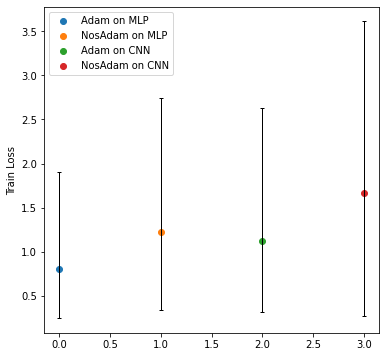

In [ ]:
fig = plt.figure(figsize=(6, 6))
plt.scatter(x=[0], y=[mean_all_train_adam_mlp], label='Adam on MLP')
plt.errorbar(x=[0], y=[mean_all_train_adam_mlp], yerr=[[fifth_percentile_train_adam_mlp],[ninety_fifth_percentile_train_adam_mlp]], ecolor='black', capsize=2, elinewidth=1)
plt.scatter(x=[1], y=[mean_all_train_nosadam_mlp], label='NosAdam on MLP')
plt.errorbar(x=[1], y=[mean_all_train_nosadam_mlp], yerr=[[fifth_percentile_train_nosadam_mlp],[ninety_fifth_percentile_train_nosadam_mlp]], ecolor='black', capsize=2, elinewidth=1)

plt.scatter(x=[2], y=[mean_all_train_adam_cnn], label = 'Adam on CNN')
plt.errorbar(x=[2], y=[mean_all_train_adam_cnn], yerr=[[fifth_percentile_train_adam_cnn],[ninety_fifth_percentile_train_adam_cnn]], ecolor='black', capsize=2, elinewidth=1)
plt.scatter(x=[3], y=[mean_all_train_nosadam_cnn], label = 'NosAdam on CNN')
plt.errorbar(x=[3], y=[mean_all_train_nosadam_cnn], yerr=[[fifth_percentile_train_nosadam_cnn],[ninety_fifth_percentile_train_nosadam_cnn]], ecolor='black', capsize=2, elinewidth=1)
plt.ylabel('Train Loss', fontsize = 10)
plt.legend(loc = 'upper left')
plt.savefig('bootsrapping.pdf')
plt.show()

Plot for test error

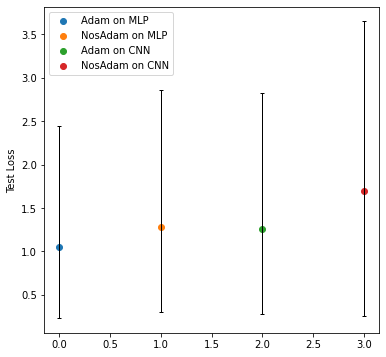

In [ ]:
# Train plot, each index in x will be a different optimizer and y its values
fig = plt.figure(figsize=(6, 6))
plt.scatter(x=[0], y=[mean_all_test_adam_mlp], label='Adam on MLP')
plt.errorbar(x=[0], y=[mean_all_test_adam_mlp], yerr=[[fifth_percentile_test_adam_mlp],[ninety_fifth_percentile_test_adam_mlp]], ecolor='black', capsize=2, elinewidth=1)
plt.scatter(x=[1], y=[mean_all_test_nosadam_mlp], label='NosAdam on MLP')
plt.errorbar(x=[1], y=[mean_all_test_nosadam_mlp], yerr=[[fifth_percentile_test_nosadam_mlp],[ninety_fifth_percentile_test_nosadam_mlp]], ecolor='black', capsize=2, elinewidth=1)

plt.scatter(x=[2], y=[mean_all_test_adam_cnn], label = 'Adam on CNN')
plt.errorbar(x=[2], y=[mean_all_test_adam_cnn], yerr=[[fifth_percentile_test_adam_cnn],[ninety_fifth_percentile_test_adam_cnn]], ecolor='black', capsize=2, elinewidth=1)
plt.scatter(x=[3], y=[mean_all_test_nosadam_cnn], label = 'NosAdam on CNN')
plt.errorbar(x=[3], y=[mean_all_test_nosadam_cnn], yerr=[[fifth_percentile_test_nosadam_cnn],[ninety_fifth_percentile_test_nosadam_cnn]], ecolor='black', capsize=2, elinewidth=1)
plt.ylabel('Test Loss', fontsize = 10)
plt.legend(loc = 'upper left')
plt.savefig('bootsrapping_test.pdf')
plt.show()